In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/5g-nidd-dataset/Combined.csv


In [2]:
import shutil

input_path = '/kaggle/input/5g-nidd-dataset'
output_path = '/kaggle/temp/5g-nidd-dataset'
# Copy dataset into working directory
shutil.copytree(input_path, output_path)

'/kaggle/temp/5g-nidd-dataset'

In [3]:
cd /kaggle/temp/5g-nidd-dataset

/kaggle/temp/5g-nidd-dataset


In [4]:
!pip install fancyimpute
!pip install torch

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 39.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.0/299.0 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 99.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 48.1 MB/s eta 0:00:00
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29880 sha256=17e99eaffddc4432b6a122c1db621d934e4f2ac8d51343d8532c7449680f2a95
  Stored in directory: /root/.cache/pip/wheels/7b/0c/d3/ee82d1fbdcc0858d96434af108608d01703505d453720c84ed
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11329 sha256=372f67684889e80e4d3bd6b7037f007e6a01cf5f1418744e15adf3d4def53b22
  Sto

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests, zipfile, io
import missingno as msno
import multiprocessing
import scipy
import sklearn
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm
import torch.nn.functional as F
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import fancyimpute
from fancyimpute import IterativeImputer
from sklearn.preprocessing import LabelEncoder

(CVXPY) Mar 13 12:52:42 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Version of ortools (9.4.1874) is too old. Expected >= 9.5.0.')
(CVXPY) Mar 13 12:52:42 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Version of ortools (9.4.1874) is too old. Expected >= 9.5.0.')


In [6]:
pd.set_option('future.no_silent_downcasting', True)

In [7]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
print('Device:', torch.device('cuda:0'))
device

Torch 2.1.2 CUDA 12.1
Device: cuda:0


device(type='cuda')

In [8]:
# number of subprocesses to use for data loading
num_workers = multiprocessing.cpu_count()

# how many samples per batch to load
batch_size = 64

# percentage of data set to use as validation
valid_size = 0.15

In [9]:
df = pd.read_csv('Combined.csv', low_memory=False)
print(df.shape)
df.head()

(1215890, 52)


,Unnamed: 0,Seq,Dur,RunTime,Mean,Sum,Min,Max,Proto,sTos,...,sVid,dVid,SrcTCPBase,DstTCPBase,TcpRtt,SynAck,AckDat,Label,Attack Type,Attack Tool
0,0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,icmp,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,Benign,Benign,Benign
1,1,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,icmp,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,Benign,Benign,Benign
2,2,3,4.998020,4.998020,4.998020,4.998020,4.998020,4.998020,udp,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,Benign,Benign,Benign
3,3,4,4.998037,4.998037,4.998037,4.998037,4.998037,4.998037,udp,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,Benign,Benign,Benign
4,4,5,4.999453,4.999453,4.999453,4.999453,4.999453,4.999453,udp,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,Benign,Benign,Benign


In [10]:
num_classes = df['Attack Type'].nunique()
labels = df['Attack Type'].unique()
print(labels)
print(num_classes)

['Benign' 'SYNScan' 'TCPConnectScan' 'UDPScan' 'ICMPFlood' 'UDPFlood'
 'SYNFlood' 'HTTPFlood' 'SlowrateDoS']
9


In [11]:
# Define a function to impute NaN values with the most frequent value in the group
def impute_most_frequent(group):
    mode_value = group.mode().iloc[0] if not group.mode().empty else np.nan
    return group.fillna(mode_value)

def handle_missing_values(df):
    df.drop_duplicates(inplace=True)
    df.drop(['sVid', 'dVid'], axis=1, inplace=True)
    df.dropna(subset=['sTos', 'sHops', 'sTtl', 'sDSb'], how='any', inplace=True)
    df[['dTtl', 'dDSb', 'dTos', 'dHops', 'SrcGap', 'DstGap']] = df.groupby('Attack Type')[['dTtl', 'dDSb', 'dTos', 'dHops', 'SrcGap', 'DstGap']].transform(impute_most_frequent)
    df['dDSb'] = df['dDSb'].fillna('cs0')
    
    df_subset_copy = df[['dTtl', 'dTos', 'dHops', 'SrcGap', 'DstGap', 'SrcTCPBase', 'DstTCPBase', 'SrcWin', 'DstWin']].copy(deep=True)
    mice_imputer = IterativeImputer()
    df_subset_copy.iloc[:, :] = mice_imputer.fit_transform(df_subset_copy)
    df[['dTtl', 'dTos', 'dHops', 'SrcGap', 'DstGap', 'SrcTCPBase', 'DstTCPBase', 'SrcWin', 'DstWin']] = df_subset_copy

In [12]:
def one_hot_encode(df):
    proto_dummies = pd.get_dummies(df.Proto, dtype=int, prefix='Proto')
    proto_dummies.drop(columns=['Proto_ipv6-icmp'], inplace=True)
    sDSb_dummies = pd.get_dummies(df.sDSb, dtype=int, prefix='sDSb')
    sDSb_dummies.drop(columns=['sDSb_39','sDSb_54', 'sDSb_4', 'sDSb_cs4'], inplace=True)
    dDSb_dummies = pd.get_dummies(df.dDSb, dtype=int, prefix='dDSb')
    dDSb_dummies.drop(columns=['dDSb_cs4'], inplace=True)
    Cause_dummies = pd.get_dummies(df.Cause, dtype=int, prefix='Cause')
    Cause_dummies.drop(columns=['Cause_Shutdown'], inplace=True)
    State_dummies = pd.get_dummies(df.State, dtype=int, prefix='State')
    State_dummies.drop(columns=['State_RSP','State_TST','State_NRS'], inplace=True)
    X, y = df.loc[:, df.columns != 'Attack Type'], df['Attack Type']
    X = pd.concat([X, proto_dummies, sDSb_dummies, dDSb_dummies, Cause_dummies, State_dummies], axis='columns')
    df = pd.concat([X, y], axis='columns')
    df.drop(columns=['Proto', 'sDSb', 'dDSb', 'Cause', 'State', 'Label', 'Unnamed: 0', 'Seq', 'RunTime', 'Mean', 'Sum', 'Min', 'Max', 'Attack Tool'], inplace=True)
    return df

In [13]:
def normalize_dataframe(df):
    X, y = df.loc[:, df.columns != 'Attack Type'], df['Attack Type']    
    std_scaler = preprocessing.StandardScaler()
    min_max_scaler = preprocessing
    std_normalized = std_scaler.fit_transform(X)
    X = pd.DataFrame(std_normalized, columns = X.columns, index = X.index)
    df = pd.concat([X, y], axis='columns')   
    return df

In [14]:
def label_encode(df):
    # define ordinal encoding
    le = LabelEncoder()
    df['Attack Type'] = le.fit_transform(df['Attack Type'].iloc[:].values.ravel())
    df['Attack Type'] = pd.to_numeric(df['Attack Type'], downcast='integer')
    return df

In [15]:
def pre_process(df):
    handle_missing_values(df)
    df = one_hot_encode(df)
    df = normalize_dataframe(df)
    df = label_encode(df)
    return df

In [16]:
df = pre_process(df)
df.head()

,Dur,sTos,dTos,sTtl,dTtl,sHops,dHops,TotPkts,SrcPkts,DstPkts,...,Cause_Status,State_ACC,State_CON,State_ECO,State_FIN,State_INT,State_REQ,State_RST,State_URP,Attack Type
0,-0.807085,-0.069046,-0.094739,-0.419379,-0.00732,1.050111,-0.973059,-0.167011,-0.146696,-0.115856,...,-1.222812,-0.030217,-0.349225,6.417179,-0.226214,-0.608798,-0.969679,-0.257637,-0.025436,0
1,-0.807085,-0.069046,-0.094739,-0.419379,-0.00732,1.050111,-0.973059,-0.167011,-0.146696,-0.115856,...,-1.222812,-0.030217,-0.349225,6.417179,-0.226214,-0.608798,-0.969679,-0.257637,-0.025436,0
2,2.147963,-0.069046,-0.094739,0.635573,-0.00732,2.452913,-0.973059,8.414004,10.443194,1.327973,...,-1.222812,-0.030217,2.863486,-0.155832,-0.226214,-0.608798,-0.969679,-0.257637,-0.025436,0
3,2.147973,-0.069046,-0.094739,0.635573,-0.00732,2.452913,-0.973059,7.205410,8.651059,1.568612,...,-1.222812,-0.030217,2.863486,-0.155832,-0.226214,-0.608798,-0.969679,-0.257637,-0.025436,0
4,2.148810,-0.069046,-0.094739,0.635573,-0.00732,2.452913,-0.973059,8.776582,10.877651,1.408186,...,-1.222812,-0.030217,2.863486,-0.155832,-0.226214,-0.608798,-0.969679,-0.257637,-0.025436,0


In [19]:
# Train Test split
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'Attack Type'], df['Attack Type'],
                                                    stratify=df['Attack Type'], 
                                                    test_size=0.15)

X_train = pd.DataFrame(X_train, columns=df.columns.to_list()[:-1])
X_test = pd.DataFrame(X_test, columns=df.columns.to_list()[:-1])
y_train = pd.DataFrame(y_train, columns=['Attack Type'])
y_test = pd.DataFrame(y_test, columns=['Attack Type'])

print("Training dataset size:", X_train.shape)
print("Testing dataset size:", X_test.shape)
print("Training target size:", y_train.shape)
print("Testing target size:", y_test.shape)

Training dataset size: (1033323, 62)
Testing dataset size: (182352, 62)
Training target size: (1033323, 1)
Testing target size: (182352, 1)


In [20]:
class CustomTabularDataset(Dataset):
    def __init__(self, data):
        # Load and preprocess your tabular data here
        self.features = torch.tensor(data['features'].values, dtype=torch.float32)
        self.labels = torch.tensor(data['labels'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [21]:
# obtain training indices that will be used for validation
num_train = len(X_train)
indices = list(range(num_train))

np.random.shuffle(indices)
split = int(np.floor(valid_size * (df.shape[0])))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [22]:
print('Training set size:', num_train - split)
print('Validation set size:', split)
print('Testing set size:', len(X_test))

Training set size: 850972
Validation set size: 182351
Testing set size: 182352


In [24]:
train_data = {'features': X_train,  # Your feature data (Pandas DataFrame or similar)
        'labels': y_train}     # Your label data

dataset = CustomTabularDataset(train_data)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)

In [25]:
# Number of features
num_features = X_train.shape[1]

In [26]:
# Creating a PyTorch class
# input_features ==> 12 ==> 32
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Building an linear encoder with Linear
        # layer followed by Tanh activation function
        # input_features ===> 12
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(num_features, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 16),
            torch.nn.Tanh(),
            torch.nn.Linear(16, 12),
            torch.nn.Tanh(),  
        )
        
        # Dense neural network layers
        self.dense_nn = torch.nn.Sequential(
            torch.nn.Linear(12, 32),  # Input size is 12 from the encoder
            torch.nn.BatchNorm1d(32),            
            torch.nn.ReLU(), 
            torch.nn.Dropout(0.2),            
            torch.nn.Linear(32, 64),
            torch.nn.BatchNorm1d(64),                
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),              
            torch.nn.Linear(64, 32),
            torch.nn.BatchNorm1d(32),                
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),            
            torch.nn.Linear(32, num_classes),  # Output size is the number of classes
            torch.nn.Softmax(dim=1)
        )        

    def forward(self, x):
        encoded = self.encoder(x)
        output = self.dense_nn(encoded)
        return output

In [27]:
# Model Initialization
model = Autoencoder()

# Validation using MSE Loss function
loss_function = torch.nn.CrossEntropyLoss()

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
                            lr = 0.001,
                            weight_decay = 1e-8)


In [28]:
# number of epochs to train the model
n_epochs = 16

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity
train_loss_min = np.Inf # set initial "min" to infinity

# Lists to store training and validation accuracy during training
training_loss = np.array([])
validation_loss = np.array([])

training_accuracy = np.array([])
validation_accuracy = np.array([])

# Moving model tensor to GPU if available
model = model.to(device)

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss and accuracy
    train_loss = 0.0
    valid_loss = 0.0
    total_train_correct = 0
    total_train_samples = 0
    total_valid_correct = 0
    total_valid_samples = 0

    ###################
    # train the model #
    ###################

    # model by default is set to train
    model.train()

    for data, target in tqdm(train_loader):        

        # Moving input tensors to GPU if available
        data, target = data.to(device), target.to(device)

        # Forward prop:

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data.float())    
        
        # Moving output tensor to GPU if available
        output = output.to(device)

        # calculate the batch loss
        loss = loss_function(output, target.reshape(-1).long())
        
        # Backward prop:

        # clear the gradients of all optimized variables
        optimizer.zero_grad()

        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # perform a single optimization step (parameter update)
        optimizer.step()

        # Metrics:

        # update training loss
        train_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(output, 1)
        total_train_correct += (predicted == target.view(*predicted.shape)).sum().item()
        total_train_samples += target.size(0)


    ######################
    # validate the model #
    ######################

    model.eval() # prep model for evaluation

    for data, target in tqdm(valid_loader):
        
        # Moving input tensors to GPU if available
        data, target = data.to(device), target.to(device)
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data.float())
        output = output.to(device)
        
        # calculate the loss
        loss = loss_function(output, target.reshape(-1).long())        
        
        # update running validation loss
        valid_loss += loss.item()
        
        # Calculate validation accuracy
        _, predicted = torch.max(output, 1)
        total_valid_correct += (predicted == target.view(*predicted.shape)).sum().item()
        total_valid_samples += target.size(0)


    # print training/validation statistics
    
    train_acc = 100 * total_train_correct / total_train_samples
    valid_acc = 100 * total_valid_correct / total_valid_samples
    
    training_accuracy = np.append(training_accuracy, train_acc)
    validation_accuracy = np.append(validation_accuracy, valid_acc)
    
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)
    
    training_loss = np.append(training_loss, train_loss)
    validation_loss = np.append(validation_loss, valid_loss)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch,
        train_loss,
        valid_loss
    ))
    
    print('Epoch: {} \tTraining Accuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        epoch,
        train_acc,
        valid_acc
    ))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min and train_loss <= train_loss_min:
        print('Training loss decreased ({:.6f} --> {:.6f}).'.format(
            train_loss_min,
            train_loss))
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
        torch.save(model.state_dict(), 'model_pytorch_autoencoders.pt')
        valid_loss_min = valid_loss
        train_loss_min = train_loss

100%|██████████| 2850/2850 [00:09<00:00, 300.39it/s]


Epoch: 1 	Training Loss: 1.391426 	Validation Loss: 1.377563
Epoch: 1 	Training Accuracy: 98.346949 	Validation Accuracy: 99.437349
Training loss decreased (inf --> 1.391426).
Validation loss decreased (inf --> 1.377563).  Saving model ...


100%|██████████| 2850/2850 [00:09<00:00, 309.28it/s]


Epoch: 2 	Training Loss: 1.378452 	Validation Loss: 1.376958
Epoch: 2 	Training Accuracy: 99.359791 	Validation Accuracy: 99.499866
Training loss decreased (1.391426 --> 1.378452).
Validation loss decreased (1.377563 --> 1.376958).  Saving model ...


100%|██████████| 2850/2850 [00:09<00:00, 295.73it/s]


Epoch: 3 	Training Loss: 1.377866 	Validation Loss: 1.377336
Epoch: 3 	Training Accuracy: 99.410439 	Validation Accuracy: 99.462027


100%|██████████| 2850/2850 [00:09<00:00, 307.18it/s]


Epoch: 4 	Training Loss: 1.377825 	Validation Loss: 1.376995
Epoch: 4 	Training Accuracy: 99.415374 	Validation Accuracy: 99.492737


100%|██████████| 2850/2850 [00:09<00:00, 294.92it/s]


Epoch: 5 	Training Loss: 1.377608 	Validation Loss: 1.377311
Epoch: 5 	Training Accuracy: 99.437349 	Validation Accuracy: 99.466414


100%|██████████| 2850/2850 [00:09<00:00, 309.75it/s]


Epoch: 6 	Training Loss: 1.376260 	Validation Loss: 1.375781
Epoch: 6 	Training Accuracy: 99.572254 	Validation Accuracy: 99.616673
Training loss decreased (1.378452 --> 1.376260).
Validation loss decreased (1.376958 --> 1.375781).  Saving model ...


100%|██████████| 2850/2850 [00:09<00:00, 291.95it/s]


Epoch: 7 	Training Loss: 1.376614 	Validation Loss: 1.375617
Epoch: 7 	Training Accuracy: 99.535590 	Validation Accuracy: 99.633125


100%|██████████| 2850/2850 [00:09<00:00, 297.30it/s]


Epoch: 8 	Training Loss: 1.376168 	Validation Loss: 1.375598
Epoch: 8 	Training Accuracy: 99.580715 	Validation Accuracy: 99.635867
Training loss decreased (1.376260 --> 1.376168).
Validation loss decreased (1.375781 --> 1.375598).  Saving model ...


100%|██████████| 2850/2850 [00:09<00:00, 296.40it/s]


Epoch: 9 	Training Loss: 1.376643 	Validation Loss: 1.377470
Epoch: 9 	Training Accuracy: 99.531712 	Validation Accuracy: 99.447220


100%|██████████| 2850/2850 [00:09<00:00, 311.92it/s]


Epoch: 10 	Training Loss: 1.376198 	Validation Loss: 1.378944
Epoch: 10 	Training Accuracy: 99.577072 	Validation Accuracy: 99.301896


100%|██████████| 2850/2850 [00:09<00:00, 307.71it/s]


Epoch: 11 	Training Loss: 1.376558 	Validation Loss: 1.377532
Epoch: 11 	Training Accuracy: 99.540408 	Validation Accuracy: 99.441736


100%|██████████| 2850/2850 [00:09<00:00, 297.50it/s]


Epoch: 12 	Training Loss: 1.376261 	Validation Loss: 1.375570
Epoch: 12 	Training Accuracy: 99.569551 	Validation Accuracy: 99.638061


100%|██████████| 2850/2850 [00:09<00:00, 304.48it/s]


Epoch: 13 	Training Loss: 1.376534 	Validation Loss: 1.378951
Epoch: 13 	Training Accuracy: 99.542876 	Validation Accuracy: 99.299702


100%|██████████| 2850/2850 [00:09<00:00, 285.63it/s]


Epoch: 14 	Training Loss: 1.376196 	Validation Loss: 1.375833
Epoch: 14 	Training Accuracy: 99.576602 	Validation Accuracy: 99.611189


100%|██████████| 2850/2850 [00:09<00:00, 295.31it/s]


Epoch: 15 	Training Loss: 1.376302 	Validation Loss: 1.376625
Epoch: 15 	Training Accuracy: 99.565908 	Validation Accuracy: 99.532221


100%|██████████| 2850/2850 [00:10<00:00, 276.71it/s]

Epoch: 16 	Training Loss: 1.376213 	Validation Loss: 1.376277
Epoch: 16 	Training Accuracy: 99.574017 	Validation Accuracy: 99.567318


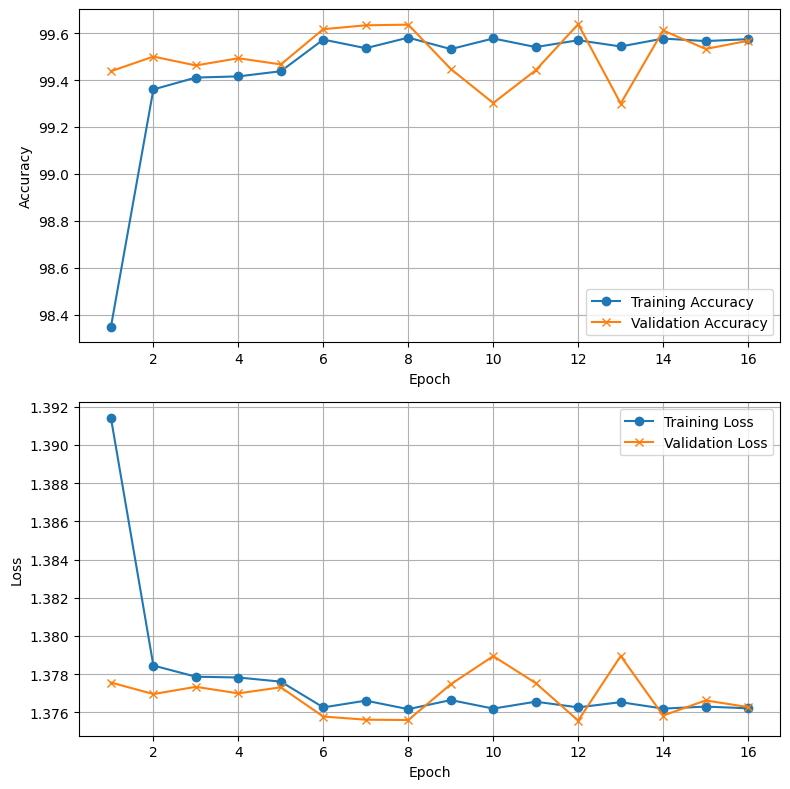

In [29]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8))
epochs = np.arange(1, n_epochs+1)

# First row for accuracy
ax[0].plot(epochs, training_accuracy, label='Training Accuracy', marker='o')
ax[0].plot(epochs, validation_accuracy, label='Validation Accuracy', marker='x')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy', color='black')
ax[0].tick_params(axis='y', labelcolor='black')
ax[0].legend(loc='lower right')
ax[0].grid(True)


# Second row for loss
ax[1].plot(epochs, training_loss, label='Training Loss', marker='o')
ax[1].plot(epochs, validation_loss, label='Validation Loss', marker='x')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss', color='black')
ax[1].tick_params(axis='y', labelcolor='black')
ax[1].legend(loc='upper right')
ax[1].grid(True)

plt.tight_layout()
plt.show()

Testing phase:

In [30]:
print("Testing dataset size:", X_test.shape)
print("Testing target size:", y_test.shape)

X_test.head()

Testing dataset size: (182352, 62)
Testing target size: (182352, 1)


,Dur,sTos,dTos,sTtl,dTtl,sHops,dHops,TotPkts,SrcPkts,DstPkts,...,Cause_Start,Cause_Status,State_ACC,State_CON,State_ECO,State_FIN,State_INT,State_REQ,State_RST,State_URP
321026,0.717735,-0.069046,-9.473906e-02,-0.329976,-7.320131e-03,-0.352692,-9.730588e-01,-0.126725,-0.092389,-0.115856,...,-0.816804,0.817787,-0.030217,-0.349225,-0.155832,-0.226214,-0.608798,1.031269,-0.257637,-0.025436
1010867,0.719005,-0.069046,-1.773502e-16,-0.329976,1.190749e-13,-0.352692,-1.939318e-13,-0.126725,-0.092389,-0.115856,...,-0.816804,0.817787,-0.030217,-0.349225,-0.155832,-0.226214,-0.608798,1.031269,-0.257637,-0.025436
141875,1.893564,-0.069046,-1.773502e-16,-0.329976,1.190749e-13,-0.352692,-1.939318e-13,-0.086438,-0.038082,-0.115856,...,-0.816804,0.817787,-0.030217,-0.349225,-0.155832,-0.226214,-0.608798,1.031269,-0.257637,-0.025436
487847,-0.807085,-0.069046,-9.473906e-02,-0.329976,-7.320131e-03,-0.352692,-9.730588e-01,-0.167011,-0.146696,-0.115856,...,-0.816804,0.817787,-0.030217,-0.349225,-0.155832,-0.226214,-0.608798,1.031269,-0.257637,-0.025436
920222,-0.807085,-0.069046,-1.773502e-16,-0.329976,1.190749e-13,-0.352692,-1.939318e-13,-0.167011,-0.146696,-0.115856,...,-0.816804,0.817787,-0.030217,-0.349225,-0.155832,-0.226214,-0.608798,1.031269,-0.257637,-0.025436


In [31]:
y_test.head()

,Attack Type
321026,0
1010867,7
141875,7
487847,0
920222,7


In [32]:
test_data = {'features': X_test,  # Your feature data (Pandas DataFrame or similar)
        'labels': y_test}     # Your label data

test_dataset = CustomTabularDataset(test_data)

In [33]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
    num_workers=num_workers)

In [34]:
model.load_state_dict(torch.load('model_pytorch_autoencoders.pt'))

<All keys matched successfully>

In [39]:
le_name_mapping = {'Benign': 0, 'HTTPFlood': 1, 'ICMPFlood': 2, 'SYNFlood': 3, 'SYNScan': 4, 'SlowrateDoS': 5, 'TCPConnectScan': 6, 'UDPFlood': 7, 'UDPScan': 8}
le_name_mapping

{'Benign': 0,
 'HTTPFlood': 1,
 'ICMPFlood': 2,
 'SYNFlood': 3,
 'SYNScan': 4,
 'SlowrateDoS': 5,
 'TCPConnectScan': 6,
 'UDPFlood': 7,
 'UDPScan': 8}

In [40]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0

class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))

# Moving model tensor to GPU if available
model = model.to(device)

model.eval() # prep model for evaluation

for data, target in tqdm(test_loader):
    
    # Moving input tensors to GPU if available
    data, target = data.to(device), target.to(device)    
    
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data.float())
    output = output.to(device)    
    
    # calculate the loss
    loss = loss_function(output, target.reshape(-1).long())
    
    # update test loss
    test_loss += loss.item()*data.size(0)
    
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    
    # calculate test accuracy for each object class
    for i in range(data.shape[0]):
        label = int(target.data[i].item())
        class_correct[label] += int(correct[i].item())
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

label_map = {}
for k, v in le_name_mapping.items():
    label_map[v] = k

for i in range(num_classes):
    if class_total[i] > 0:
        print(f'Test Accuracy of {str(i)}-{label_map[i]:<25}: {100 * class_correct[i] / class_total[i]:.6f}% ({int(np.sum(class_correct[i])):<2}/{int(np.sum(class_total[i])):<2})')
    else:
        print(f'Test Accuracy of {label_map[i]:<25}: N/A (no training examples)')

print(f'\nTest Accuracy (Overall): {100. * np.sum(class_correct) / np.sum(class_total):.6f}% ({int(np.sum(class_correct))} / {int(np.sum(class_total))})')

100%|██████████| 2850/2850 [00:16<00:00, 173.71it/s]

Test Loss: 1.375518

Test Accuracy of 0-Benign                   : 99.956721% (71598/71629)
Test Accuracy of 1-HTTPFlood                : 99.521826% (21021/21122)
Test Accuracy of 2-ICMPFlood                : 100.000000% (173/173)
Test Accuracy of 3-SYNFlood                 : 85.665295% (1249/1458)
Test Accuracy of 4-SYNScan                  : 99.800399% (3000/3006)
Test Accuracy of 5-SlowrateDoS              : 97.438235% (10688/10969)
Test Accuracy of 6-TCPConnectScan           : 99.368351% (2989/3008)
Test Accuracy of 7-UDPFlood                 : 100.000000% (68601/68601)
Test Accuracy of 8-UDPScan                  : 99.790444% (2381/2386)

Test Accuracy (Overall): 99.642450% (181700 / 182352)
